In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np
import time
import wandb

In [2]:
device = torch.device('cuda:0')

data = torch.tensor(pd.read_csv("../data/mnist/train.csv", header=None).values)
x, y = (data[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(data[:, 0].long(), 10).to(device)

test = torch.tensor(pd.read_csv("../data/mnist/test.csv", header=None).values)
x_test, y_test = (test[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(test[:, 0].long(), 10).to(device)

In [3]:
class Real(nn.Module): 
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        return x
model = Real()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1.2e-3)
losses = []

hparams = {
    "batch_size": 80,
    "num_epochs": 80,
    "model": "lenet 300 100",
    "dataset": "mnist",
    "optimizer": "adam",
    "learning_rate": 1.2e-3,  # 1.2e-5, 1.2e-7 can be tried
}

wandb.init(project="QuatLT23", name="test", config=hparams)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: peithonking. Use `wandb login --relogin` to force relogin


In [4]:
batch_size = hparams["batch_size"]
num_epochs = hparams["num_epochs"]
for epoch in trange(num_epochs):
    for i in range(0, len(x), batch_size):
        batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
        optimiser.zero_grad()
        output = model(batch_x)
        loss = F.mse_loss(output, batch_y)
        loss.backward()
        optimiser.step()
    losses.append(loss.item())
    
    # find accuracy don;t forget to detach
    train_acc = (torch.argmax(model(x), dim=1) == torch.argmax(y, dim=1)).float().mean().item()
    test_acc = (torch.argmax(model(x_test), dim=1) == torch.argmax(y_test, dim=1)).float().mean().item()
    
    wandb.log({"loss": loss.item(), "train_acc": train_acc, "test_acc": test_acc})

100%|██████████| 80/80 [00:22<00:00,  3.50it/s]


In [5]:
wandb.finish()

loss,█▄▃▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▆████▇█▇▇▇▆▇▇▇▇▇▆▇▆▆▆▇▆▇▅▆▆▇▇▆▆▇▆▆▆▆▆▆▆
train_acc,▁▅▆▇▇▇▇█████████████████████████████████
loss,5e-05
test_acc,0.9774
train_acc,0.9998


Training Accuracy: 99.98%
Testing Accuracy: 97.74%


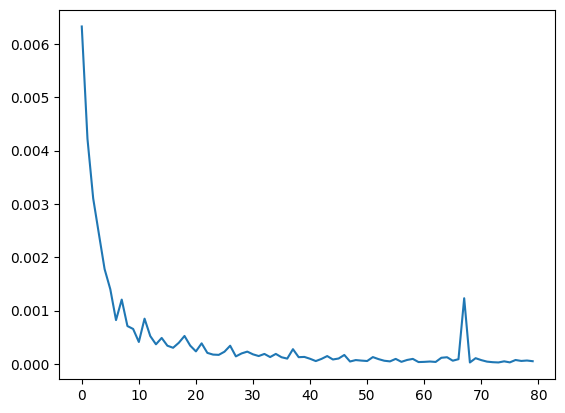

In [6]:
accuracy = (model(x).argmax(1) == y.argmax(1)).sum().item()/len(x)
print(f"Training Accuracy: {accuracy*100:.2f}%")

accuracy = (model(x_test).argmax(1) == y_test.argmax(1)).sum().item()/len(x_test)
print(f"Testing Accuracy: {accuracy*100:.2f}%")

plt.plot(range(len(losses)), losses)